### Embedding and Cosine Similarity

In this section we are collecting the sequences to embed them using a Pretrained model from Rostlab's [ProtTrans](https://github.com/agemagician/ProtTrans). After this embedding the cosine similarity of each embedded protein sequence is achieved and graphed as a heatmap.

In [1]:
# BioPython library for collecting the sequences from cif files
from Bio.PDB import PDBList
from Bio.PDB.MMCIFParser import MMCIFParser

In [16]:
# Data manipulation libraries
import os
import re
import io

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, DoubleType, MapType
from pyspark.ml.linalg import DenseVector, VectorUDT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Creating the spark session
spark = SparkSession.builder \
    .master("spark://master:7077")\
    .appName("Proteindata spark application")\
    .config("spark.executor.memory", "4096m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/18 21:39:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Creating the spark context
sc = spark.sparkContext

### Getting the file paths

In [5]:
# Getting the file paths
base_path = '/data_files/cif_files'
base_path_edit = '/data_files/cif_files/{}'
file_names = os.listdir(base_path)
file_list = [base_path_edit.format(i) for i in file_names][:200]
files_rdd = sc.parallelize(file_list)

In [6]:
# Counting all of the paths to see if there are any errors
files_rdd.count()

200

### Parsing the file

#### Parsing the files using the Biopython library to get the sequence. The output of this function is the id of the protein, sequence and the length. 

In [7]:
def parse_file(file):

    cif_parser = MMCIFParser(QUIET=True) # CIF file parser
    length = 0 # Setting the length initially to 0 for error correction
    name = file.split('/')[3].split('.')[0] # Getting the id of the protein
    structure = cif_parser.get_structure("protein", file) # getting structure ? try "protein"

    # Dictionary for residue names
    d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    # The output of the cif parser needs to be looped in order to get the sequence itself    
    for model in structure:
        for chain in model:
            sequence = [d3to1.get(residue.get_resname(), 'X') for residue in chain.get_residues()]
            length = len(sequence)
    
    return name,sequence,length

### Creating a dataframe 
#### A dataframe containing the id, length and the token of the each sequence

In [8]:
# Creating an RDD for the tokens
def tokens_df_creator(file_path):

    data = []
    name, sequence, length = parse_file(file_path)
    row_value = {
        'id':name,
        'length':length,
        'tokens':sequence,
    }
    #if 32 <= row_value['length'] <= 256:
    data.append(Row(**row_value))
    
    return data

# Turning the RDD into a DF for easier usage
tokens_rdd = files_rdd.flatMap(tokens_df_creator) # FlatMap applied to the RDD


In [9]:
tokens_df = tokens_rdd.toDF()

#### Checking output

In [ ]:
tokens_df.take(1)

In [10]:
#Checking if there is any missing data
tokens_df.where(tokens_df.length==0).show()
# running twice showString at NativeMethodAccessorImpl.java:0
#8 minutes
#12 minutes ?

+---+------+------+
| id|length|tokens|
+---+------+------+
+---+------+------+



### Frequency analysis for every sequence

#### Here I am going to create a dataframe consisting of the frequency analysis of each sequence. The dataframe will consist of columns as, sequence id, most frequent amino acid (mf_aa), most frequent amino acid percentage (mf_aa_freq).

In [11]:
tokens_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- length: long (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [11]:
temp = (
    tokens_df
    .withColumn("Dist", F.array_distinct("Tokens"))  # Get distinct tokens for the current sequence
    .withColumn(
        "Counts",
        F.expr(
            """
            transform(
                Dist,
                x -> aggregate(
                    Tokens,
                    0,
                    (acc, y) -> IF(y = x, acc + 1, acc)
                )
            )
            """
        )  # Count the frequencies of each token
    )
    .withColumn(
        "Map",
        F.arrays_zip("Dist", "Counts")  # Combine tokens and their counts into an array of structs
    )
    .drop("Dist", "Counts")  # Drop intermediate columns
)

In [12]:
# Step 2: Add sorted map, most frequent, and second most frequent tokens
freq_df = temp.withColumn(
    "SortedMap",  # Sort the Map by counts in descending order
    F.expr(
        """
        array_sort(
            Map,
            (first, second) -> CASE WHEN first['Counts'] > second['Counts'] THEN -1 ELSE 1 END
        )
        """
    )
).withColumn(
    "mf_aa",  # Most frequent token as a list
    F.expr("array(SortedMap[0]['Dist'])")
).withColumn(
    "mf_aa_count",  # Count of the most frequent token
    F.expr("SortedMap[0]['Counts']")
).withColumn(
    "mf_aa_freq",  # Frequency of the most frequent token
    F.col("mf_aa_count") / F.size(F.col("Tokens"))  # Divide count by total number of tokens
).drop('tokens','length','Map','SortedMap','mf_aa_count')

In [ ]:
freq_df.printSchema()

In [13]:
freq_pd = freq_df.toPandas()
# Maybe to csv?

### Histogram of most frequent tokens

<Axes: >

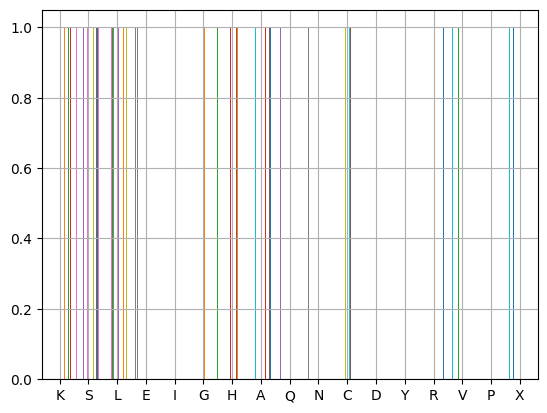

In [14]:
freq_pd['mf_aa'].hist()

### Histogram of the frequency of most frequent tokens

<Axes: >

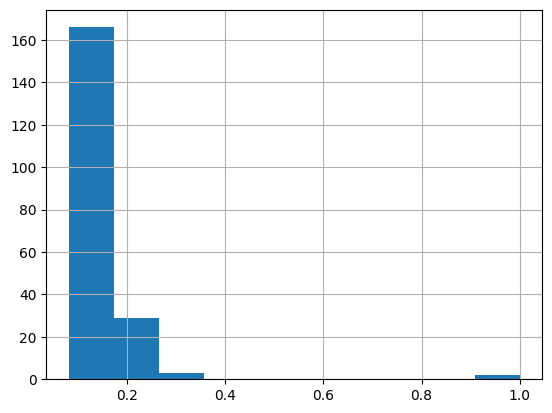

In [15]:
freq_pd['mf_aa_freq'].hist()

In [19]:
print(freq_pd['mf_aa'])

0      [K]
1      [S]
2      [K]
3      [L]
4      [E]
      ... 
195    [C]
196    [L]
197    [E]
198    [E]
199    [A]
Name: mf_aa, Length: 200, dtype: object


TypeError: unhashable type: 'list'

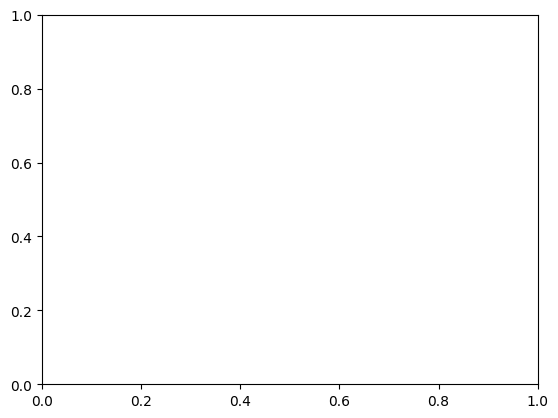

In [18]:
plt.bar(freq_pd['mf_aa_freq'])

### Creating the .vec file using ProtBert

#### Here I shortly showed what I did in order to achieve the .vec file. Since the ProtBert model didn't have such file I looped through the residues and created the vocabulary. 

```python
import numpy as np
#transformer model for embedding space creation
from transformers import BertModel, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False ) # change model and tokenizer to t5
model_embedd = BertModel.from_pretrained("Rostlab/prot_bert")

vocab = ['L','A','G','V','E','S','I','K','R','D','T','P','N','Q','F','Y','M','H','C','W','X','U','B','Z','O']
# Path to save the .vec file
vec_file_path = 'prot_bert.vec'

# Open the file in write mode
with open(vec_file_path, 'w') as f:
    # Write the header (vocab size and vector dimension)
    f.write(f"{len(vocab)} {outputs.last_hidden_state.size()[2]}\n")
    
    # Write each word and its corresponding vector
    for letter in vocab:
        encoded_input = tokenizer.encode(letter,return_tensors='pt').to(device)
        outputs = model_embedd(input_ids=encoded_input)
        vector = outputs.last_hidden_state[0,0].detach().numpy()
        vector_str = ' '.join(map(str, vector))  # Convert the vector to a string
        f.write(f"{letter} {vector_str}\n")
```

#### The problem with this implementation is that all the semantic information between the residues in a sequence is lost since the .vec file is created for each residue. This is highly affecting our output since this semantic knowledge contain ancestoral, functional, structural and many more information.

### Loading the embedding pre_trained model

#### We loaded the .vec file as a standard python dictionary which is at first only available in the driver node. But using the Pyspark's broadcast function this dictionary can be broadcasted to all of the nodes which enables the executors to have the dictionaries in their local environment.

In [10]:
# Creating the dictionary from the .vec file
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    data = {}
    for line in fin:
        letter_token = line.rstrip().split()
        data[letter_token[0]] = DenseVector([float(letter) for letter in letter_token[1:]])
    return data

vec_dict = load_vectors('/data_files/prot_bert.vec')

In [11]:
# Broadcasting the dictionary
vec_broadcast = sc.broadcast(vec_dict)

### Creating list of vectors

In [12]:
# Embedding the sequence
# The embedding is done using a UDF an alternative idea might be by using a dataframe and giving conditions ?
@F.udf(ArrayType(VectorUDT()))
def embed_sequence(tokens_list):
    return [vec_broadcast.value[token] for token in tokens_list if token in vec_dict]


In [13]:
# The embeddings are added a new column (UDF applied to the DataFrame)
tokens_df = tokens_df.withColumn("embeddings",embed_sequence(tokens_df.tokens))

#### Output check

In [45]:
tokens_df.take(1)
# 13 mins

[Row(id='2gtj', length=96, tokens=['E', 'K', 'K', 'E', 'Q', 'K', 'E', 'K', 'E', 'K', 'K', 'E', 'Q', 'E', 'I', 'K', 'K', 'K', 'F', 'K', 'L', 'T', 'G', 'P', 'I', 'Q', 'V', 'I', 'H', 'L', 'A', 'K', 'A', 'C', 'C', 'D', 'V', 'K', 'G', 'G', 'K', 'N', 'E', 'L', 'S', 'F', 'K', 'Q', 'G', 'E', 'Q', 'I', 'E', 'I', 'I', 'R', 'I', 'T', 'D', 'N', 'P', 'E', 'G', 'K', 'W', 'L', 'G', 'R', 'T', 'A', 'R', 'G', 'S', 'Y', 'G', 'Y', 'I', 'K', 'T', 'T', 'A', 'V', 'E', 'I', 'D', 'Y', 'D', 'S', 'L', 'K', 'L', 'K', 'K', 'D', 'L', 'E'], embeddings=[DenseVector([-0.0114, 0.0267, -0.0439, -0.2368, 0.1542, -0.0646, -0.0559, -0.0703, -0.0036, -0.0111, 0.0229, 0.0961, -0.0482, 0.0832, 0.05, -0.1097, -0.0542, 0.089, -0.0141, -0.0478, 0.0498, 0.102, -0.1078, 0.0012, 0.0138, 0.0356, -0.0661, 0.0474, 0.0658, -0.0734, 0.0164, 0.0706, -0.0899, -0.0177, 0.0811, -0.0478, 0.0229, 0.086, -0.1653, -0.1281, 0.0688, 0.0946, 0.0709, 0.0495, 0.0651, -0.3145, 0.102, -0.0307, 0.068, 0.0714, 0.0568, -0.0793, -0.0178, -0.1962, 0.0108, 

In [ ]:
#freq_df.take(1)

### Taking the mean of the list of the vectors (len(sequence) x 1024) to achieve one vector with length 1024

##### To reduce the dimensions of the embeddings we used the same aproach as Rostlab did in order to achieve an embedding for the protein sequence.
$$

$$

In [14]:
# Creating another udf to get the mean of each embedding row
@F.udf(VectorUDT())
def mean_calculator(embedding,length):
    mean_embedding = sum(embedding)/length
    return mean_embedding   

# Created mean embedding is added as a new column
tokens_df = tokens_df.withColumn("mean_embed",mean_calculator(tokens_df.embeddings,tokens_df.length))

In [15]:
# Selecting a subset of the tokens_df in order to persist in the memory for future usage
mean_embed_rdd = tokens_df.select("id","mean_embed").rdd
mean_embed_rdd = mean_embed_rdd.persist() # Persisting to get the data quickly since the cosine similarity is done on this dataframe
mean_embed_rdd.take(3)
# 18 mins

[Row(id='2gtj', mean_embed=DenseVector([0.0397, 0.0427, -0.0577, -0.2323, 0.1652, -0.0599, -0.0319, -0.0757, -0.0646, -0.0491, 0.0335, 0.0626, -0.0253, 0.0857, 0.0522, -0.092, -0.0463, 0.0876, -0.0023, -0.0488, 0.0656, 0.0813, -0.0675, -0.0346, -0.0435, 0.0134, -0.05, 0.0371, 0.0694, -0.0343, -0.0617, 0.1067, -0.064, -0.0596, 0.0596, -0.0277, 0.0347, 0.0665, -0.1228, -0.1228, 0.1053, 0.1265, 0.0874, 0.0104, 0.0224, -0.2372, 0.1267, -0.0259, 0.0428, 0.0384, 0.0127, -0.0887, -0.0234, -0.1277, -0.0064, 0.0219, -0.001, -0.139, -0.0448, -0.0307, -0.0983, -0.0772, 0.0786, -0.0506, -0.0784, -0.0406, -0.0295, -0.0127, 0.1354, -0.0753, -0.1574, 0.0609, -0.0365, -0.0931, 0.0633, -0.0494, -0.0897, 0.0303, 0.0382, 0.0535, -0.0055, 0.0957, 0.0036, 0.0635, 0.0818, -0.0931, -0.074, -0.1012, 0.2456, -0.0448, -0.0003, -0.1137, -0.0065, -0.124, -0.0122, 0.1259, 0.331, 0.0258, 0.1134, 0.0372, -0.0653, 0.0028, -0.0644, 0.0449, 0.0229, -0.171, -0.0107, -0.0727, 0.0045, 0.0633, -0.0688, 0.0154, 0.0613, 0.03

In [16]:
#mean_embed_rdd.repartition(10) didn't work
mean_embed_rdd.getNumPartitions()

4

In [43]:
# Creating a DF using the persisted RDD
mean_embed_df = mean_embed_rdd.toDF()
#mean_embed_df.printSchema(2)

#### Checking output

In [ ]:
take5 = mean_embed_df.take(5)

In [ ]:
print(len(take5[3][1]))

In [ ]:
print(take5[1][0])

### Cosine similarity

#### Here we created another udf for the calculation of the cosine similarity for each protein sequence. With this we can see if there are any similarities between protein sequences.

In [51]:
def cos_sim_local(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [50]:
@F.udf(DoubleType())
def cos_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

### For small amount of data

In [ ]:
cartesian_rdd = mean_embed_rdd.cartesian(mean_embed_rdd)
result_rdd = cartesian_rdd.map(
    lambda pair: (pair[0][0], pair[1][0], cos_sim_local(pair[0][1], pair[1][1]))
)

# Convert to DataFrame
result_df = spark.createDataFrame(result_rdd, ["row_idx1", "row_idx2", "dot_product"])
result_df.count()

25/01/16 15:25:51 WARN TaskSetManager: Lost task 0.0 in stage 2.0 (TID 3) (10.67.22.219 executor 0): TaskKilled (Stage cancelled: Job 2 cancelled )


### Large amounts of data

In [18]:
cartesian_rdd = mean_embed_rdd.cartesian(mean_embed_rdd)
upper_triangle_rdd = cartesian_rdd.filter(lambda x: x[0][0] < x[1][0])

In [19]:
result_rdd = upper_triangle_rdd.map(
    lambda pair: (pair[0][0], pair[1][0], cos_sim_local(pair[0][1], pair[1][1]))
)

# Convert to DataFrame
result_df = spark.createDataFrame(result_rdd, ["row_idx1", "row_idx2", "dot_product"])
result_df.count()
# 11 mins

4950

In [20]:
result_rdd.getNumPartitions()

16

In [58]:
filtered_df = result_df.filter(result_df["dot_product"] < 0.978)

In [59]:
filtered_df.count()

15

Getting the unique ids to create the heatmap

In [60]:
row_idx1 = filtered_df.select('row_idx1').distinct().rdd.map(lambda r: r[0]).collect()
row_idx2 = filtered_df.select('row_idx2').distinct().rdd.map(lambda r: r[0]).collect()

In [61]:
idx = list(set(row_idx1 + row_idx2))

In [62]:
filtered_mean_embed_df = mean_embed_df.filter(mean_embed_df["id"].isin(idx) == True)

In [63]:
filtered_mean_embed_df.collect()

[Row(id='7ywr', mean_embed=DenseVector([0.0338, 0.0446, -0.0627, -0.228, 0.1679, -0.0567, -0.0338, -0.0649, -0.0768, -0.0506, 0.0196, 0.0704, -0.0251, 0.083, 0.056, -0.0891, -0.034, 0.0898, 0.0006, -0.0458, 0.0575, 0.0876, -0.077, -0.0405, -0.0146, 0.0133, -0.0558, 0.032, 0.0557, -0.0458, -0.0455, 0.1009, -0.0868, -0.0462, 0.0596, -0.0389, 0.0402, 0.0665, -0.1223, -0.1246, 0.1016, 0.1331, 0.0883, 0.0252, 0.0378, -0.237, 0.1288, -0.0305, 0.0439, 0.0194, 0.0079, -0.0639, -0.0327, -0.1415, -0.0051, 0.0207, -0.0026, -0.1247, -0.0476, -0.0328, -0.1054, -0.0805, 0.0589, -0.0402, -0.07, -0.037, -0.0199, -0.0082, 0.1349, -0.0797, -0.1437, 0.0463, -0.0386, -0.0578, 0.0542, -0.0541, -0.0861, 0.0223, 0.0526, 0.0401, 0.0004, 0.0788, 0.0199, 0.0567, 0.0685, -0.0985, -0.0763, -0.1213, 0.2269, -0.0423, -0.0145, -0.1062, -0.0031, -0.1287, -0.0104, 0.1127, 0.3196, 0.015, 0.1226, 0.04, -0.05, -0.0106, -0.0648, 0.0396, 0.037, -0.1628, -0.0122, -0.0647, 0.012, 0.0607, -0.0613, 0.02, 0.0536, 0.041, -0.1041

In [64]:
df2 = (
    filtered_mean_embed_df.alias('a')
    .crossJoin(filtered_mean_embed_df.alias('b'))
    .withColumn(
        'cs',
        cos_sim(
            'a.mean_embed',
            'b.mean_embed')
    )
    .groupby('a.id') # Grouping by the id's
    .pivot('b.id') # Pivoting on the same id's
    .sum('cs') # Collecting the cosine similarities
)

#### For heatmap

In [65]:
cos_df = df2.toPandas()
cos_df = cos_df.sort_values('id')

cod_df = cos_df.set_index('id')

In [66]:
cod_df.head()

,1gjx,1kmx,1mw4,1wt7,2cry,2d96,2l02,2lfd,2lg4,2row,2rqr,6uf2,7ywr,8e22,8wwx
id,,,,,,,,,,,,,,,
1gjx,1.000000,0.986452,0.975205,0.983866,0.981724,0.971902,0.995391,0.995554,0.987268,0.993861,0.981677,0.981978,0.995053,0.983060,0.982171
1kmx,0.986452,1.000000,0.984325,0.997449,0.982531,0.976569,0.994904,0.994666,0.996578,0.996249,0.984879,0.985440,0.993561,0.984837,0.987193
1mw4,0.975205,0.984325,1.000000,0.979922,0.986825,0.979402,0.978309,0.981374,0.971154,0.983435,0.988812,0.987037,0.980210,0.990041,0.987636
1wt7,0.983866,0.997449,0.979922,1.000000,0.982571,0.976368,0.991544,0.990628,0.995732,0.994355,0.984063,0.984244,0.991470,0.983135,0.985599
2cry,0.981724,0.982531,0.986825,0.982571,1.000000,0.996033,0.984084,0.982609,0.973543,0.986125,0.999074,0.998200,0.984596,0.997804,0.996374


#### Heatmap trial

<Axes: >

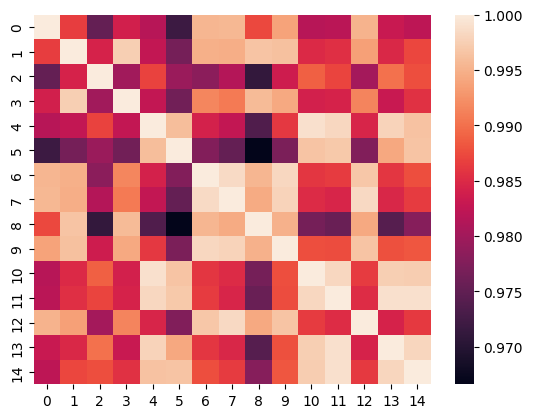

In [67]:
import seaborn as sns

data2 = cod_df.values.flatten().tolist()
data2_array = np.array(data2).reshape(len(cod_df.columns),len(cod_df.columns))
sns.heatmap(data2_array)

Here we see that the embeddings look very similar. I will continue the invastigation by checking the distribution of amino acids in the most similar and least similar sequence couples.

### Analysis of some proteins

In [75]:
minimum_cs = filtered_df.select(F.min(filtered_df["dot_product"])).collect()


[Row(min(dot_product)=0.9665867697427074)]

In [82]:
proteins = filtered_df.filter(filtered_df["dot_product"] == minimum_cs[0][0]).collect()
protein1, protein2 = proteins[0][0],proteins[0][1]

In [83]:
protein1

'2d96'

In [145]:
mean_embed_rdd.unpersist()

MapPartitionsRDD[27] at javaToPython at NativeMethodAccessorImpl.java:0

In [87]:
sc.stop()

In [88]:
spark.stop()